In [2]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b
import time

from keras.applications import vgg16
from keras import backend as K
from keras.layers import Input
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
img_width, img_height = 800, 600

image_path = './2007_000323.jpg'
output_name = 'results/im'

In [4]:
img_size = (img_height, img_width, 3)

inp_img = Input(batch_shape=(1,) + img_size)

In [5]:
model = vgg16.VGG16(input_tensor=inp_img,
                    weights='imagenet', include_top=False)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (1, 600, 800, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (1, 600, 800, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (1, 600, 800, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (1, 300, 400, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (1, 300, 400, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (1, 300, 400, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (1, 150, 200, 128)        0         
__________

In [7]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    # img = np.asarray(255*np.random.random((img_height, img_width, 3)), dtype='uint8')
    img = img_to_array(img)
    # print img.shape
    img = np.expand_dims(img, axis=0)
    # print img.shape
    img = vgg16.preprocess_input(img)
    # print img.shape
    return img

In [8]:
def deprocess_image(x):
    x = x.reshape((img_height, img_width, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [9]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

for key in layer_dict:
    print key, layer_dict[key]

block4_pool <keras.layers.pooling.MaxPooling2D object at 0x7f5e779c8e10>
block1_pool <keras.layers.pooling.MaxPooling2D object at 0x7f5e77d5fe10>
block4_conv1 <keras.layers.convolutional.Conv2D object at 0x7f5e77c9fd50>
block2_conv1 <keras.layers.convolutional.Conv2D object at 0x7f5e77d0ddd0>
block2_conv2 <keras.layers.convolutional.Conv2D object at 0x7f5e77cf7fd0>
block4_conv2 <keras.layers.convolutional.Conv2D object at 0x7f5e77cadcd0>
block4_conv3 <keras.layers.convolutional.Conv2D object at 0x7f5e77c54590>
block2_pool <keras.layers.pooling.MaxPooling2D object at 0x7f5e77cb3390>
block5_conv3 <keras.layers.convolutional.Conv2D object at 0x7f5e779fd6d0>
block5_conv2 <keras.layers.convolutional.Conv2D object at 0x7f5e779dafd0>
block5_conv1 <keras.layers.convolutional.Conv2D object at 0x7f5e779eee10>
block3_pool <keras.layers.pooling.MaxPooling2D object at 0x7f5e77c8b810>
block1_conv2 <keras.layers.convolutional.Conv2D object at 0x7f5e78003a90>
block1_conv1 <keras.layers.convolutional.C

In [22]:
layer_out = layer_dict['block4_conv2'].output
layer_out_01 = layer_dict['block5_conv2'].output


loss = -0.7*K.mean(layer_out[:, :, :, :5]
loss -= 0.3*K.mean(layer_out_01[:, :, :, :2])
loss += 0.05*K.mean(inp_img)

In [23]:
grads = K.gradients(loss, inp_img)
# print grads

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([inp_img], outputs)

In [24]:
def eval_loss_and_grads(x):
    x = x.reshape((1,) + img_size)
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [25]:
settings = {
    'jitter': 0,
}

# fmin_l_bfgs_b?

Start of iteration 0
Current loss value: -231.924
('Image saved as', 'results/new_img_at_iteration_0.png')
Iteration 0 completed in 6s
Start of iteration 1
Current loss value: -486.996
('Image saved as', 'results/new_img_at_iteration_1.png')
Iteration 1 completed in 5s
Start of iteration 2
Current loss value: -786.036
('Image saved as', 'results/new_img_at_iteration_2.png')
Iteration 2 completed in 5s
Start of iteration 3
Current loss value: -1106.5
('Image saved as', 'results/new_img_at_iteration_3.png')
Iteration 3 completed in 5s
Start of iteration 4
Current loss value: -1325.99
('Image saved as', 'results/new_img_at_iteration_4.png')
Iteration 4 completed in 5s
Start of iteration 5
Current loss value: -1656.92
('Image saved as', 'results/new_img_at_iteration_5.png')
Iteration 5 completed in 5s
Start of iteration 6
Current loss value: -1906.17
('Image saved as', 'results/new_img_at_iteration_6.png')
Iteration 6 completed in 5s
Start of iteration 7
Current loss value: -2127.93
('Imag

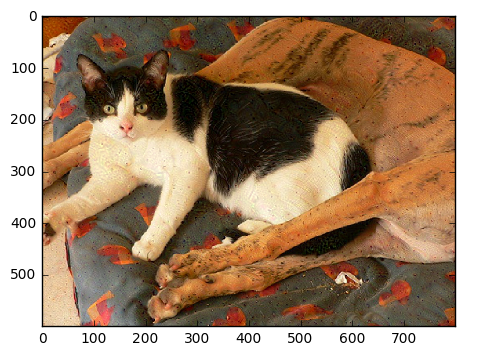

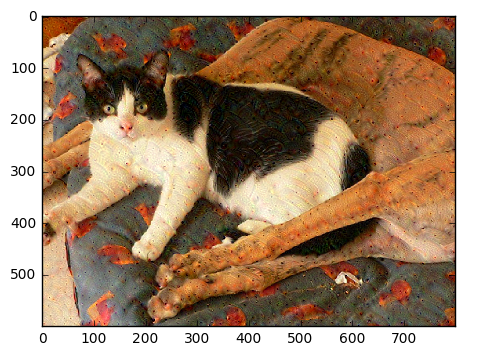

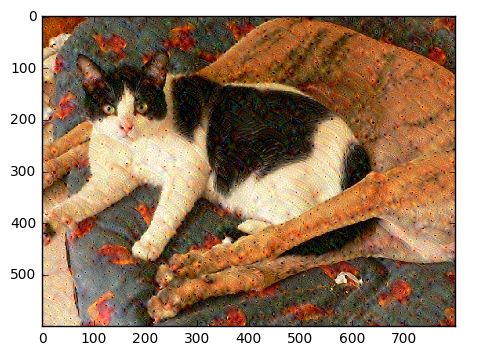

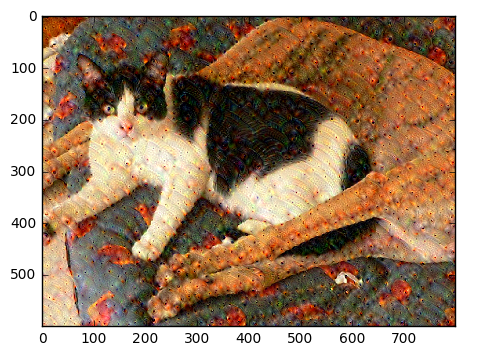

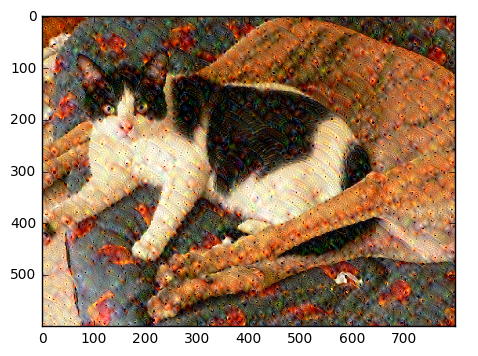

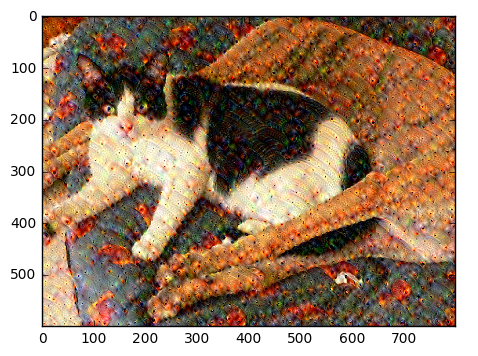

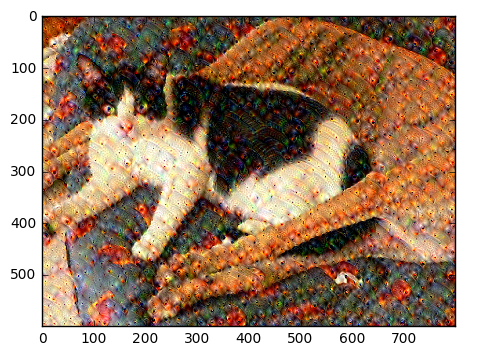

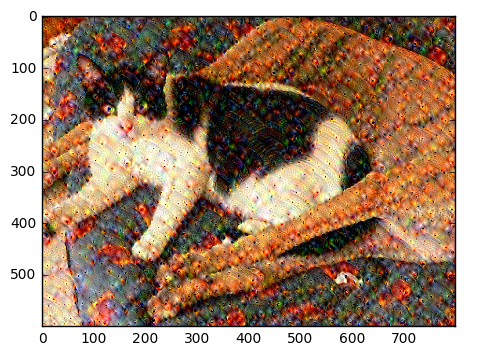

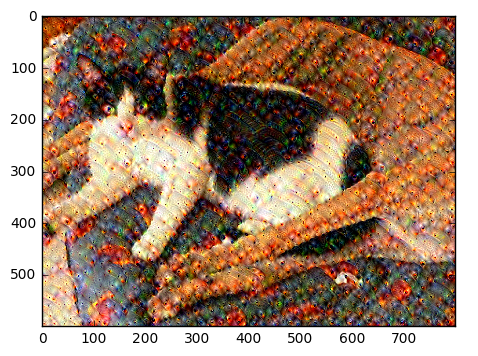

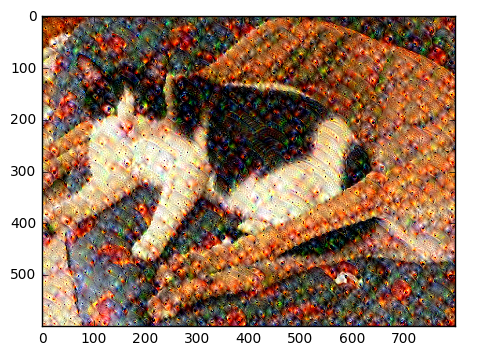

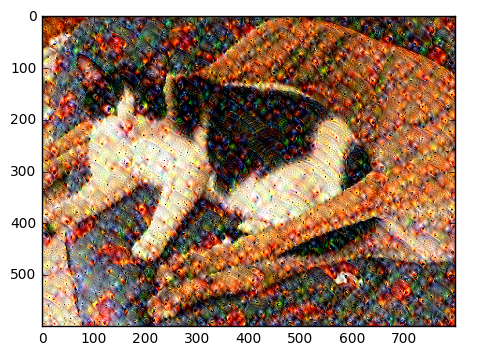

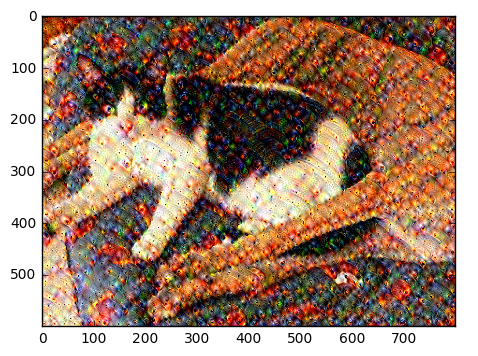

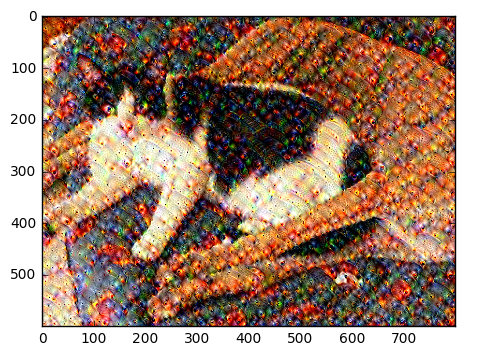

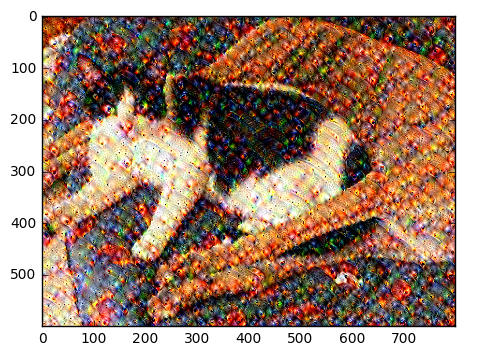

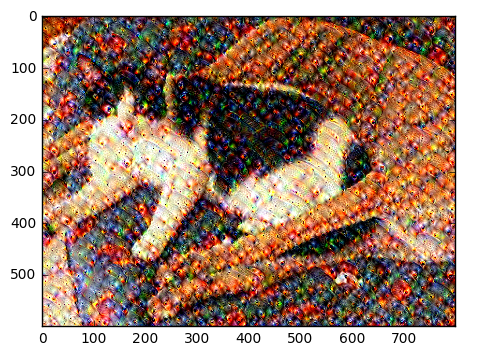

In [26]:
x = preprocess_image('./2007_001825.jpg')

for i in range(15):
    print 'Start of iteration', i
    start_time = time.time()

    random_jitter = (settings['jitter'] * 2) * (np.random.random(img_size) - 0.5)
    x += random_jitter

    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=7)
    print 'Current loss value:', min_val
    
    # Decode the dream and save it
    x = x.reshape(img_size)
    x -= random_jitter
    img = deprocess_image(np.copy(x))
    
    plt.figure(i)
    plt.imshow(img)
    
    fname = 'results/new_img' + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
plt.show()